(tensor-network-1d)=

# 1D Algorithms

Although `quimb.tensor` aims to be an interactive and general
base for arbitrary tensor networks, it also has fast
implementations of the following:

Static:

- 1-site {class}`~quimb.tensor.tensor_dmrg.DMRG1` (OBC and PBC)
- 2-site {class}`~quimb.tensor.tensor_dmrg.DMRG2` (OBC and PBC)
- 1-site {class}`~quimb.tensor.tensor_dmrg.DMRGX`

Time Evolving:

- {class}`~quimb.tensor.tensor_1d_tebd.TEBD`

Two site DMRGX and TDVP slot into the same framework and should be
easy to implement. All of these are based on 1D tensor networks, the
primary representation of which is the *matrix product state*.

## Matrix Product States

The basic constructor for MPS is {class}`~quimb.tensor.tensor_1d.MatrixProductState`.
This is a subclass of {class}`~quimb.tensor.tensor_core.TensorNetwork`,
with a special tagging scheme (`MPS.site_tag_id`) and special index
naming sceme (`MPS.site_ind_id`).
It is also possible to instantiate a MPS directly from a dense vector using
{meth}`~quimb.tensor.tensor_1d.MatrixProductState.from_dense`, though
this is obviously not efficient for many sites.

In the following, we just generate a random MPS, and demonstrate some basic functionality.

In [1]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *

In [2]:
p = MPS_rand_state(L=20, bond_dim=50)
print(f"Site tags: '{p.site_tag_id}', site inds: '{p.site_ind_id}'")

Site tags: 'I{}', site inds: 'k{}'


In [3]:
# in a notebook we can explore a colorized representation:
p

MatrixProductState(tensors=20, indices=39, L=20, max_bond=50)

In [4]:
p.show()  # 1D tensor networks also have a ascii ``show`` method

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●──●
│  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │


We can then __canonicalize__ the MPS:

In [5]:
p.left_canonize()
p.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──●
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │


And we can compute the inner product as:

In [6]:
p.H @ p

0.9999999999999998

This relies on them sharing the same physical indices, ``site_ind_id``, 
which the conjugated copy ``p.H`` naturally does.

Like any TN, we can __graph__ the overlap for example, and make use of the 
site tags to color it:

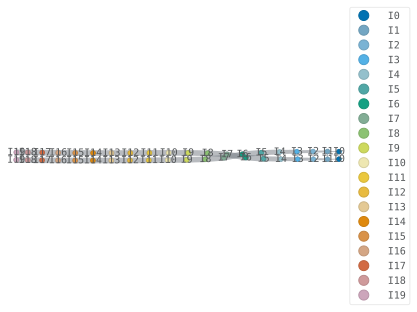

In [12]:
(p.H & p).draw(color=[f'I{i}' for i in range(20)])

I.e. we used the fact that 1D tensor networks are tagged with the structure `"I{}"`
denoting their sites. See the {ref}`examples` for how to fix the positions of tensors when drawing them.

We can also **add** MPS, and **multiply/divide** them by scalars:

In [13]:
p2 = (p + p) / 2
p2.show()

 4 8 16 32 64 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
●─●─●──●──●──●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●━━━●
│ │ │  │  │  │   │   │   │   │   │   │   │   │   │   │   │   │   │   │


Which doubles the bond dimension, as expected, but should still be normalized:

In [14]:
p2.H @ p2

0.9999999999999991

Because the MPS is the addition of two identical states, it should also __compress__ right back down:

In [15]:
p2.compress(form=10)
p2.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 32 16 8 4 2 
>─>─>─>──>──>──>──>──>──>──●──<──<──<──<──<──<─<─<─<
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │ │


Where we have also set the __orthogonality center__ at the site 10.

When tensor networks are imbued with a ``structure``, they 
can be indexed with integers and slices, which automatically get
converted using ``TN.site_tag_id``:

In [16]:
p2[10]  # get the tensor(s) with tag 'I10'.

Tensor(shape=(50, 50, 2), inds=('_24c68bAAAAJ', '_24c68bAAAAK', 'k10'), tags=oset(['I10']))

Note the tensor has matching physical index ``'k10'``.

This tensor is the orthogonality center so:

       ─>─>─●─<─<─        ╭─●─╮
    ... │ │ │ │ │ ...  =  │ │ │
       ─>─>─●─<─<─        ╰─●─╯
           i=10            i=10

should compute the normalization of the *whole* state:

In [17]:
p2[10].H @ p2[10]  # all indices match -> inner product

1.0

Or equivalently:

In [18]:
p2[10].norm()

1.0

If two tensor networks with the same ``structure`` are combined, it is propagated.
For example ``(p2.H & p2)`` can still be sliced.

Since the MPS is in canonical form, left and right pieces of the overlap
should form the identity. The following forms a TN of the inner product, 
selects the *2* tensors corresponding to the last site (``-1``), contracts them, 
then gets the underlying data:

In [19]:
((p2.H & p2).select(-1) ^ all).data.round(12)  # should be close to the identity

array([[ 1., -0.],
       [-0.,  1.]])

Various builtin quantities are available to compute too:

- {meth}`~quimb.tensor.tensor_1d.MatrixProductState.entropy`
- {meth}`~quimb.tensor.tensor_1d.MatrixProductState.schmidt_gap`
- {meth}`~quimb.tensor.tensor_1d.MatrixProductState.magnetization`
- {meth}`~quimb.tensor.tensor_1d.TensorNetwork1DVector.correlation`
- {meth}`~quimb.tensor.tensor_1d.MatrixProductState.logneg_subsys`

and other non-trivial quantities such as the mutual information
can be easily calculated using a combination of -
{meth}`~quimb.tensor.tensor_1d.MatrixProductState.partial_trace_compress`
and {func}`~quimb.approx_spectral_function` (see {ref}`Examples`).
Finally, many quantities can be computed using local 'gates' see the section
{ref}`gating`.

## Matrix Product Operators

The raw MPO class is {class}`~quimb.tensor.tensor_1d.MatrixProductOperator`,
which shares many features with {class}`~quimb.tensor.tensor_1d.MatrixProductState`,
but has both a `MPO.upper_ind_id` and a `MPO.lower_ind_id`.

Here we generate a random hermitian MPO and form a 'overlap' network with our MPS:


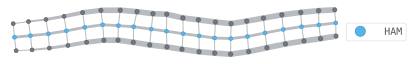

In [20]:
A = MPO_rand_herm(20, bond_dim=7, tags=['HAM'])
pH = p.H

# This inplace modifies the indices of each to form overlap
p.align_(A, pH)

(pH & A & p).draw(color='HAM', iterations=20, initial_layout='kamada_kawai')

Compute the actual contraction (``...`` means contract everything, but use the structure if possible):

In [21]:
(pH & A & p) ^ ...

-1.0420173017863053e-06

## Building Hamiltonians

There are various built-in MPO hamiltoanians:

- {class}`~quimb.tensor.tensor_builder.MPO_ham_heis`
- {class}`~quimb.tensor.tensor_builder.MPO_ham_ising`
- {class}`~quimb.tensor.tensor_builder.MPO_ham_XY`
- {class}`~quimb.tensor.tensor_builder.MPO_ham_mbl`
- ...

These all accept a `cyclic` argument to enable periodic boundary
conditions (PBC), and a `S` argument to set the size of spin.

For generating other spin Hamiltonians see
{class}`~quimb.tensor.tensor_builder.SpinHam1D`, or consider using the raw
constructor of {class}`~quimb.tensor.tensor_1d.MatrixProductOperator`.

## Quick DMRG2 Intro

First we build a Hamiltonian term by term (though we could just use {class}`~quimb.tensor.tensor_builder.MPO_ham_heis`):

In [22]:
builder = SpinHam1D(S=1)
builder += 1/2, '+', '-'
builder += 1/2, '-', '+'
builder += 1, 'Z', 'Z'
H = builder.build_mpo(L=100)

Then we construct the 2-site DMRG object ({class}`~quimb.tensor.tensor_dmrg.DMRG2`), with the Hamiltonian MPO and a default sequence of maximum bond dimensions and a bond compression cutoff:

In [23]:
dmrg = DMRG2(H, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

The ``DMRG`` object will automatically detect OBC/PBC. Now we can solve to a certain absolute energy tolerance, showing progress and a schematic of the final state:

In [24]:
dmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=(10/10), cutoff:1e-10


100%|###########################################| 99/99 [00:01<00:00, 93.61it/s]

Energy: -138.71354542441696 ... not converged.
SWEEP-2, direction=R, max_bond=(10/20), cutoff:1e-10



100%|##########################################| 99/99 [00:00<00:00, 250.23it/s]

Energy: -138.93662608086498 ... not converged.
SWEEP-3, direction=R, max_bond=(20/100), cutoff:1e-10



100%|###########################################| 99/99 [00:01<00:00, 74.36it/s]

Energy: -138.9400463321153 ... not converged.
SWEEP-4, direction=R, max_bond=(58/100), cutoff:1e-10



100%|###########################################| 99/99 [00:04<00:00, 21.45it/s]

Energy: -138.94008554031018 ... not converged.
SWEEP-5, direction=R, max_bond=(90/200), cutoff:1e-10



100%|###########################################| 99/99 [00:08<00:00, 11.55it/s]

Energy: -138.94008604176477 ... converged!


True

In [25]:
dmrg.state.show(max_width=80)

     3 9 27 53 64 75 80 83 87 89 92 93 94 94 95 96 95 94 94 93 93 93 92 92    
... >─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>── ...
    │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │      
                                 ...                                  
     91 91 91 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90     
... >──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──> ...
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │    
                                 ...                                  
    90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 9    
... ──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>──>─ ...
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │     
                                 ...                                  
    0 90 90 91 90 90 90 90 90 92 93 94 95 95 96 97 95 95 93 90 87 83 78 73  

There are many options stored in the dict `DMRG.opts` - an explanation of each of
these is given in {func}`~quimb.tensor.tensor_dmrg.get_default_opts`, and it may be
necessary to tweak these to achieve the best performance/accuracy, especially for
PBC (see {ref}`examples`).

:::{note}
Performance Tips

1. Make sure numpy is linked to a fast BLAS (e.g. MKL version that comes with conda).
2. Install slepc4py, to use as the iterative eigensolver, it's faster than scipy.
3. If the hamiltonian is real, compile and use a real version of SLEPC
   (set the environment variable PETSC_ARCH before launch).
4. Periodic systems are in some ways easier to solve if *longer*, since this
   reduces correlations the 'long way round'.
:::


## Quick TEBD Intro

Time Evolving Block Decimation ({class}`~quimb.tensor.tensor_tebd.TEBD`) requires not a
MPO but a specficiation of the local, interacting term(s) of a Hamiltonian.
This is encapsulated in the {class}`~quimb.tensor.tensor_tebd.LocalHam1D` object, which is
initialized with the sum of two site terms `H2` and one-site terms (if any), `H1`.

{class}`~quimb.tensor.tensor_tebd.LocalHam1D` objects can also be built directly
from a {class}`~quimb.tensor.tensor_builder.SpinHam1D` instance
using the {meth}`~quimb.tensor.tensor_builder.SpinHam1D.build_local_ham` method.
There are also the following built-in LocalHam1D Hamiltonians:

- {class}`~quimb.tensor.tensor_builder.ham1d_heis`
- {class}`~quimb.tensor.tensor_builder.ham1d_ising`
- {class}`~quimb.tensor.tensor_builder.ham1d_XY`

Here we build a {class}`~quimb.tensor.tensor_tebd.LocalHam1D` using a
`SpinHam1D`:


In [26]:
builder = SpinHam1D(S=1 / 2)
builder.add_term(1.0, 'Z', 'Z')
builder.add_term(0.9, 'Y', 'Y')
builder.add_term(0.8, 'X', 'X')
builder.add_term(0.6, 'Z')

H = ham_1d_heis(20, bz=0.1)

# check the two site term
H.terms[0, 1]

array([[ 0.175,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.275,  0.5  ,  0.   ],
       [ 0.   ,  0.5  , -0.225,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.325]])

Then we set up an initial state and the {class}`~quimb.tensor.tensor_tebd.TEBD` object itself -
which mimics the general api of {class}`quimb.Evolution`:

In [27]:
psi0 = MPS_neel_state(20)
tebd = TEBD(psi0, H)

Now we are ready to evolve. By setting a ``tol``, the required timestep ``dt`` is computed for us:

In [28]:
tebd.update_to(T=3, tol=1e-3)

t=3, max-bond=34: 100%|#########################################################| 100/100 [00:02<00:00, 45.10%/s]


After the evolution we can see that entanglement has been generated throughout the chain:

In [29]:
tebd.pt.show()

 2 4 8 16 29 34 33 34 33 34 33 34 33 34 29 16 8 4 2 
>─>─>─>──>──>──>──>──>──>──>──>──>──>──>──>──>─>─>─●
│ │ │ │  │  │  │  │  │  │  │  │  │  │  │  │  │ │ │ │


A more complete demonstration can be found in the {ref}`examples`.

(gating)=

## Gates: compute local quantities and simulate circuits

On top of the builtin methods mentioned earlier
({meth}`~quimb.tensor.tensor_1d.MatrixProductState.entropy`,
{meth}`~quimb.tensor.tensor_1d.MatrixProductState.schmidt_gap`,
{meth}`~quimb.tensor.tensor_1d.MatrixProductState.magnetization`,
{meth}`~quimb.tensor.tensor_1d.TensorNetwork1DVector.correlation`,
{meth}`~quimb.tensor.tensor_1d.MatrixProductState.logneg_subsys`, etc.),
many other quantities are encapsulated by the
{meth}`~quimb.tensor.tensor_1d.TensorNetwork1DVector.gate` method,
which works on any 1D tensor network vector (MPS, MERA, etc.).
This 'applies' a given operator to 1 or more sites, whilst maintaining
the 'physical', outer indices.
This not only directly allows quantum circuit style computation simulation
but also makes local quantities (i.e. non-MPO) easy to compute:

In [30]:
import quimb as qu
Z = qu.pauli('Z')

# compute <psi0|Z_i|psi0> for neel state above
[
    psi0.gate(Z, i).H @ psi0
    for i in range(10)
]

[(1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j),
 (1+0j),
 (-1+0j)]

There are four ways in which a gate can be applied:

- Lazily (`contract=False`) - the gate is added to the tensor network
  but nothing is contracted. This is the default.
- Lazily with split (`contract='split-gate'`) - the gate is split before
  it is added to the network.
- Eagerly (`contract=True`) - the gate is contracted into the tensor
  network. If the gate acts on more than one site this will produce
  larger tensors.
- Swap and Split (`contract='swap+split'`) - sites will be swapped
  until adjacent, the gate will be applied and the resulting
  tensor split, then the sites swapped back into their original positions.
  This explicitly maintains the exact structure of an MPS (at the cost of
  increasing bond dimension), unlike the other two methods.

Here's a quantum computation style demonstration of the lazy method:

In [31]:
import quimb as qu

# some operators to apply
H = qu.hadamard()
CNOT = qu.controlled('not')

# setup an intitial register of qubits
n = 10
psi0 = MPS_computational_state('0' * n, tags='PSI0')

# apply hadamard to each site
for i in range(n):
    psi0.gate_(H, i, tags='H')

# apply CNOT to even pairs
for i in range(0, n, 2):
    psi0.gate_(CNOT, (i, i + 1), tags='CNOT')

# apply CNOT to odd pairs
for i in range(1, n - 1, 2):
    psi0.gate_(CNOT, (i, i + 1), tags='CNOT')

Note we have used the inplace ``gate_`` (with a trailing
underscore) which modifies the original ``psi0`` object.
However ``psi0`` has its physical site indices mantained
such that it overall looks like the same object:

In [32]:
sorted(psi0.outer_inds())

['k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9']

In [33]:
(psi0.H & psi0) ^ all

0.9999999999999978

But the network now contains the gates as additional tensors:

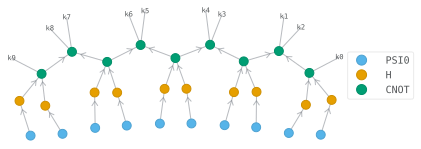

In [36]:
psi0.draw(color=['PSI0', 'H', 'CNOT'], show_tags=False, layout='neato')

With the swap and split method MPS form is always maintained, which
allows a canonical form and thus optimal trimming of singular values:

In [37]:
n = 10
psi0 = MPS_computational_state('0' * n)

for i in range(n):
    # 'swap+split' will be ignore to one-site gates
    psi0.gate_(H, i, contract='swap+split')

# use Z-phase to create entanglement
Rz = qu.phase_gate(0.42)
for i in range(n):
    psi0.gate_(Rz, i, contract='swap+split')

for i in range(0, n, 2):
    psi0.gate_(CNOT, (i, i + 1), contract='swap+split')

for i in range(1, n - 1, 2):
    psi0.gate_(CNOT, (i, i + 1), contract='swap+split')

# act with one long-range CNOT
psi0.gate_(CNOT, (2, n - 2), contract='swap+split')

MatrixProductState(tensors=10, indices=19, L=10, max_bond=4)

We now still have an MPS, but with increased bond dimension:

In [38]:
psi0.show()

 2 2 4 4 4 4 4 2 2 
>─>─>─>─>─>─>─●─●─<
│ │ │ │ │ │ │ │ │ │


Finally, the eager (``contract=True``) method works fairly simply:

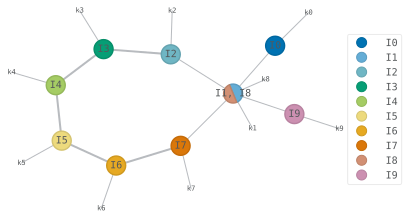

In [39]:
psi0_CNOT = psi0.gate(CNOT, (1, n - 2), contract=True)
psi0_CNOT.draw(color=[psi0.site_tag(i) for i in range(n)])

Where we can see that the gate, site 1, and site 8 have been combined
into a new rank-6 tensor.

A much more detailed run-through of quantum circuit simulation using
tensor networks and the {class}`~quimb.tensor.circuit.Circuit` object
can be found in the example {ref}`quantum-circuit-example`.